<a href="https://colab.research.google.com/github/matdcp/Data-dreamers-/blob/main/TRANSFORMER_ufficiale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Goal
In this notebook, the main objective is to implement a Named Entity Recognition (**NER**) model using the **pre-trained BioBERT** model for entity recognition in the anatomical domain. BioBERT is a version of BERT optimized for processing texts in the biological and medical fields, and it is particularly suited for tasks such as NER, where it is necessary to identify relevant entities like diseases, drugs, and anatomical structures.

#Upload cleaned dataset

In [ ]:
import pandas as pd
from google.colab import files

# Carica il file CSV
uploaded = files.upload()

Saving cleaned_dataset_NN.csv to cleaned_dataset_NN (5).csv


In [ ]:
# Leggi il file CSV con Pandas
for filename in uploaded.keys():
    df = pd.read_csv(filename)

df.head()

,id,Start,End,Label
0,Ventricular,0,11,B-Multi-tissue_structure
1,fibrillation,12,24,O
2,long,32,36,O
3,QT,37,39,O
4,syndrome,40,48,O


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
pip install transformers

In [ ]:
!pip install datasets


In [ ]:
!pip install evaluate

In [ ]:
!pip install seqeval

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import AutoTokenizer
from datasets import Dataset
import os


#Dataset Preparation
We prepare the dataset for the modeling process: the dataset contains annotated text, where each token is associated with a specific label. As the first step, we calculate the **sequence length**, defined as the difference between the "Start" and "End" positions of each token.

Next, we analyze the distribution of sequence lengths. The results show that the average sequence length is approximately 6.59 tokens, with most **sequences ranging from 4 to 9 tokens**, while the **longest sequence reaches 32 tokens**. This analysis helps us understand the typical size of the sequences in our dataset, ensuring that the tokenizer and model configurations are optimized to efficiently handle these lengths during training.

Such an analysis is crucial for tasks like padding and truncation, as it allows us to set an appropriate maximum sequence length for the model, ensuring optimized and efficient training and evaluation processes.

In [ ]:
df['sequence_length'] = df['End'] - df['Start']
print(df['sequence_length'].describe())


count    60979.000000
mean         6.588252
std          3.391699
min          1.000000
25%          4.000000
50%          7.000000
75%          9.000000
max         32.000000
Name: sequence_length, dtype: float64


We examine the **unique labels** present in the dataset to gain an understanding of the different categories involved. Subsequently, we analyze **how frequently each label appears**, revealing the overall distribution of labels within the dataset.

From the analysis, we observe that the label **"O"** (Outside) **appears most frequently**, followed by categories like "B-Cell" and "B-Multi-tissue_structure." On the other hand, certain categories, such as "I-Developing_anatomical_structure" and "I-Organism_subdivision" are significantly underrepresented, with very few occurrences. This highlights the presence of a substantial class imbalance in the dataset.


In [ ]:
# Valori unici di Label
print("\nCategorie di Label:")
print(df['Label'].unique())

# Frequenza delle etichette
print("\nDistribuzione delle etichette:")
print(df['Label'].value_counts())



Categorie di Label:
['B-Multi-tissue_structure' 'O' 'B-Organism_substance'
 'B-Organism_subdivision' 'B-Organ' 'I-Multi-tissue_structure'
 'B-Cellular_component' 'I-Cellular_component' 'B-Cell' 'I-Cell'
 'B-Immaterial_anatomical_entity' 'B-Tissue' 'I-Tissue'
 'B-Pathological_formation' 'B-Anatomical_system' 'I-Organism_substance'
 'I-Anatomical_system' 'I-Pathological_formation'
 'I-Immaterial_anatomical_entity' 'I-Organ' 'I-Organism_subdivision'
 'B-Developing_anatomical_structure' 'I-Developing_anatomical_structure']

Distribuzione delle etichette:
Label
O                                    56455
B-Cell                                 775
B-Multi-tissue_structure               639
I-Cell                                 439
B-Organ                                381
B-Pathological_formation               367
I-Multi-tissue_structure               358
B-Organism_substance                   288
I-Pathological_formation               224
B-Cellular_component                   199
B-Tiss

##Splitting the dataset
To prepare the dataset, we performed the following operations:

1. **Removal of a NER label**: The class "I-Developing_anatomical_structure" was removed from the dataset as it contained only 5 examples. A class with such a small representation would have compromised the model's predictions, reducing the reliability of its performance.

2. **Splitting into train, test and validation sets**: The dataset was split into three sets: training (70%), validation (15%), and test (15%). First, the unique IDs of the samples were randomly shuffled, and 30% of the dataset was separated into a temporary set (containing both validation and test), while 70% was allocated to the training set. The temporary set was then split into two parts, with 50% of the IDs assigned to the validation set and 50% to the test set.

3. **Difference in the sizes of validation and test sets:** The slight difference in size between the validation and test sets is due to the fact that the splitting was done based on unique IDs rather than rows. This resulted in a slight discrepancy in the actual number of rows assigned to each set, with validation being larger than test.

In [ ]:
from sklearn.utils import resample

# Rimuovere la classe I-Developing_anatomical_structure da tutto il dataset
df = df[df['Label'] != 'I-Developing_anatomical_structure']

# Suddivisione del dataset in train, validation e test
unique_ids = df['id'].unique()
shuffled_ids = pd.Series(unique_ids).sample(frac=1, random_state=42).values
train_ids, temp_ids = train_test_split(shuffled_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

train_df = df[df['id'].isin(train_ids)]
val_df = df[df['id'].isin(val_ids)]
test_df = df[df['id'].isin(test_ids)]

# Mostrare le dimensioni dei subset
print(f"Training set: {train_df.shape[0]} righe")
print(f"Validation set: {val_df.shape[0]} righe")
print(f"Test set: {test_df.shape[0]} righe")


Training set: 42163 righe
Validation set: 10320 righe
Test set: 8491 righe


In [ ]:
print(train_df['Label'].value_counts())

Label
O                                    38911
B-Cell                                 543
B-Multi-tissue_structure               464
I-Cell                                 355
B-Organ                                286
B-Pathological_formation               256
I-Multi-tissue_structure               254
B-Organism_substance                   171
I-Pathological_formation               156
B-Cellular_component                   142
B-Organism_subdivision                 131
B-Tissue                               118
I-Tissue                                71
I-Cellular_component                    55
B-Immaterial_anatomical_entity          50
I-Organism_substance                    40
I-Organ                                 38
B-Anatomical_system                     35
B-Developing_anatomical_structure       33
I-Anatomical_system                     25
I-Immaterial_anatomical_entity          16
I-Organism_subdivision                  13
Name: count, dtype: int64


##Rebalancing Training set
To address the class imbalance in the training dataset, we apply undersampling and oversampling techniques:
1. **Undersampling of the majority class**: The "O" (majority) class is undersampled to 10,000 examples, while the minority classes are separated and prepared for oversampling.

2. **Oversampling of the minority classes**: The minority classes are oversampled to 1,000 examples per class, balancing the distribution of classes in the training set.

3. **Merging and shuffling of the balanced data**: The balanced data (both majority and minority classes) are merged and randomly shuffled to form a new training set, ensuring the data is distributed randomly to avoid bias.

In [ ]:
from sklearn.utils import resample

# Separare la classe maggioritaria (O) e le altre classi nel train set
majority_class = train_df[train_df['Label'] == 'O']
minority_classes = train_df[train_df['Label'] != 'O']

# Undersampling della classe O nel train set
undersampled_majority = resample(majority_class,
                                 replace=False,  # Campionamento senza sostituzione
                                 n_samples=10000,  # Numero target (esempio: 10k)
                                 random_state=42)

# Oversampling delle classi minoritarie nel train set
balanced_minority = minority_classes.groupby('Label', group_keys=False).apply(
    lambda x: resample(x,
                       replace=True,  # Campionamento con sostituzione
                       n_samples=1000,  # Numero target (esempio: 1k per classe)
                       random_state=42)
)

# Unire i dati bilanciati nel train set
balanced_train_df = pd.concat([undersampled_majority, balanced_minority])

# Mescolare i dati bilanciati
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Controllare la nuova distribuzione delle classi nel train set
print("Distribution of classes in balanced train set:")
print(balanced_train_df['Label'].value_counts())

# Validation e test restano invariati
print("Distribution of classes in validation set:")
print(val_df['Label'].value_counts())

print("Distribution of classes in test set:")
print(test_df['Label'].value_counts())


Distribution of classes in balanced train set:
Label
O                                    10000
I-Multi-tissue_structure              1000
B-Cellular_component                  1000
I-Immaterial_anatomical_entity        1000
I-Cell                                1000
B-Cell                                1000
B-Multi-tissue_structure              1000
I-Anatomical_system                   1000
I-Organism_substance                  1000
B-Tissue                              1000
B-Organism_substance                  1000
B-Organ                               1000
I-Cellular_component                  1000
I-Organ                               1000
I-Tissue                              1000
B-Developing_anatomical_structure     1000
I-Pathological_formation              1000
I-Organism_subdivision                1000
B-Pathological_formation              1000
B-Anatomical_system                   1000
B-Organism_subdivision                1000
B-Immaterial_anatomical_entity        1000
N

<ipython-input-90-3e7acd8425d9>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_minority = minority_classes.groupby('Label', group_keys=False).apply(


#Mapping NER tags
After identifying all unique NER labels in the balanced training set, we created two mapping dictionaries:

* **tag2id**: This dictionary associates each unique NER label with a unique numeric ID. This is essential for converting the categorical labels into a format suitable for deep learning models.

* **id2tag**: This dictionary performs the reverse mapping, converting numeric IDs back into the corresponding NER labels, which helps in interpreting model predictions during evaluation.

We then applied the tag2id mapping to the training, validation, and test datasets, replacing the original NER labels with their respective numeric IDs. This conversion makes the data compatible with the Hugging Face model, enabling the model to process these numeric representations during training and evaluation.

Finally, we printed the tag2id mapping to ensure that each label has been correctly mapped to its corresponding ID.

In [ ]:
# Creiamo una lista di tutte le etichette presenti nel training set bilanciato
all_labels = balanced_train_df['Label'].unique()

# Creiamo il mapping delle etichette
tag2id = {tag: idx for idx, tag in enumerate(all_labels)}
id2tag = {idx: tag for tag, idx in tag2id.items()}

val_df = val_df.copy()
test_df = test_df.copy()

# Aggiungiamo la colonna con l'ID delle etichette nei dataset
balanced_train_df['Label_ID'] = balanced_train_df['Label'].map(tag2id)
val_df.loc[:,'Label_ID'] = val_df['Label'].map(tag2id)
test_df.loc[:,'Label_ID'] = test_df['Label'].map(tag2id)

# Controlliamo il mapping
print("Mapping delle etichette (tag2id):", tag2id)


Mapping delle etichette (tag2id): {'I-Multi-tissue_structure': 0, 'B-Cellular_component': 1, 'O': 2, 'I-Immaterial_anatomical_entity': 3, 'I-Cell': 4, 'B-Cell': 5, 'B-Multi-tissue_structure': 6, 'I-Anatomical_system': 7, 'I-Organism_substance': 8, 'B-Tissue': 9, 'B-Organism_substance': 10, 'B-Organ': 11, 'I-Cellular_component': 12, 'I-Organ': 13, 'I-Tissue': 14, 'B-Developing_anatomical_structure': 15, 'I-Pathological_formation': 16, 'I-Organism_subdivision': 17, 'B-Pathological_formation': 18, 'B-Anatomical_system': 19, 'B-Organism_subdivision': 20, 'B-Immaterial_anatomical_entity': 21}


#Preparing Data for Hugging Face
By defining the convert_labels_to_ids function, we centralize the process of converting NER labels into numeric IDs. Unlike the first approach, where the mapping was applied manually to each dataset separately, with this function we can **easily apply the same conversion to multiple datasets** (training, validation, test) in a **modular and reusable way**. The function applies the tag2id mapping to the Label column of each dataset, creating a new Label_ID column with the corresponding numeric IDs. This approach **improves code readability** and maintainability by reducing duplication and centralizing the conversion logic.

In [ ]:
# Trasforma le etichette in ID numerici usando il mapping tag2id
def convert_labels_to_ids(df, tag2id):
    df.loc[:, 'Label_ID'] = df['Label'].map(tag2id)  # Mappa direttamente i valori della colonna
    return df

# Esegui la conversione per ogni dataset
balanced_train_dataset = convert_labels_to_ids(balanced_train_df, tag2id)  # Usa il training set bilanciato
val_dataset = convert_labels_to_ids(val_df, tag2id)
test_dataset = convert_labels_to_ids(test_df, tag2id)

print("Conversione delle etichette completata!")
print(balanced_train_dataset.head())


Conversione delle etichette completata!
              id  Start  End                           Label  sequence_length  \
0       internal     65   73        I-Multi-tissue_structure                8   
1  transmembrane    285  298            B-Cellular_component               13   
2    examination    599  610                               O               11   
3      Sepharose    930  939                               O                9   
4   interstitial    679  691  I-Immaterial_anatomical_entity               12   

   Label_ID  
0         0  
1         1  
2         2  
3         2  
4         3  


#Dataset for Hugging Face
We proceed by **transforming the datasets into Hugging Face Dataset format using Dataset**.from_pandas. This format is ideal for training models within the transformers library, allowing for efficient handling of the data.

In [ ]:
# Converto i DataFrame in Dataset di Hugging Face
train_hf = Dataset.from_pandas(balanced_train_dataset)
val_hf = Dataset.from_pandas(val_dataset)
test_hf = Dataset.from_pandas(test_dataset)

#Loading tokenizer and pre-trained model (BioBERT)
* **Pre-trained model**:
The selected pre-trained model is BioBERT, specifically the "dmis-lab/biobert-base-cased-v1.1", a variant of BERT fine-tuned for biomedical text. Unlike the general-purpose BERT, BioBERT has been trained on large biomedical corpora such as PubMed and PMC (PubMed Central), which consist of scientific papers and biomedical research. This specialized training allows BioBERT to capture medical and scientific terms with a high level of precision, making it well-suited for biomedical NLP tasks such as Named Entity Recognition (NER).

* **Tokenizer:**
We load the tokenizer via the AutoTokenizer.from_pretrained() function, which automatically fetches the tokenizer associated with BioBERT. The tokenizer is responsible for splitting the text into tokens and mapping them to numeric IDs that the model understands. Additionally, it handles adding special tokens (e.g., [CLS], [SEP]) and padding/truncation to ensure the text conforms to the required input format.
One key feature of the BioBERT tokenizer is its large vocabulary tailored to the biomedical domain. It has been trained on a large number of biomedical terms, which enables it to generalize well even when handling rare or non-standard words often seen in medical texts.

* **Purpose:**
BioBERT serves as the base model, which will be fine-tuned on our specific biomedical NER task. Fine-tuning allows the model to adapt to the specific vocabulary and medical context present in our dataset.

In [ ]:
# Carichiamo il tokenizer di BioBert
model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("Tokenizer caricato:", model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenizer caricato: dmis-lab/biobert-base-cased-v1.1


#Tokenization and labels allignment
The tokenize_and_align_with_stride function tokenizes the input sequences using the Hugging Face tokenizer, ensuring that the alignment between generated tokens and NER labels is preserved. Main tokens retain their original labels, while special tokens and sub-tokens are ignored by assigning a label of -100.

Tokenization involves padding and truncating the sequences to a **maximum length of 32 tokens**. This maximum length is determined by the longest sequence in our dataset, which has a length of 32 tokens.
Additionally, the function introduces a **stride of 16 tokens**, allowing for overlapping segments. This overlap ensures that important context from the original sequence is not lost when truncating.

The function is then applied to the datasets using datasets.map(), which processes the data in batches for efficiency. Unnecessary columns, such as the original text and label columns, are removed, resulting in tokenized datasets that are ready for training.

In [ ]:
def tokenize_and_align_with_stride(examples):
    tokenized_inputs = tokenizer(
        examples["id"],  # Cambia con il tuo campo testo
        truncation=True,
        max_length=32,
        stride=16,  # Sovrapposizione tra segmenti
        is_split_into_words=False,
        return_overflowing_tokens=True
    )

    labels = []
    for i, label in enumerate(examples['Label_ID']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Ottieni il mapping parola-token
        aligned_labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:  # Token speciale o padding
                aligned_labels.append(-100)
            elif word_idx != previous_word_idx:
                aligned_labels.append(label)  # Prima occorrenza della parola
            else:
                aligned_labels.append(-100)  # Ignora token subword
            previous_word_idx = word_idx
        labels.append(aligned_labels)

    # Aggiungi le etichette ai token tokenizzati
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


In [ ]:
def process_datasets(dataset, tokenizer):
    return dataset.map(
        tokenize_and_align_with_stride,  # Usa il nome corretto della funzione
        batched=True,  # Processa in batch per velocità e robustezza
        remove_columns=['id', 'Label', 'Label_ID']  # Rimuove colonne inutili
    )

# Tokenizzazione per i tre dataset
tokenized_datasets = {}
for split, dataset in zip(["train", "validation", "test"], [train_hf, val_hf, test_hf]):
    tokenized_datasets[split] = process_datasets(dataset, tokenizer)

print("Tokenizzazione completata!")



Map:   0%|          | 0/31000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10320 [00:00<?, ? examples/s]

Map:   0%|          | 0/8491 [00:00<?, ? examples/s]

Tokenizzazione completata!


In [ ]:
# Controlla un esempio del dataset tokenizzato
print("Esempio tokenizzato (Train):")
print(tokenized_datasets["train"].select(range(5)).to_dict())


Esempio tokenizzato (Train):
{'Start': [65, 285, 599, 930, 679], 'End': [73, 298, 610, 939, 691], 'sequence_length': [8, 13, 11, 9, 12], 'input_ids': [[101, 4422, 102], [101, 14715, 3263, 12913, 18194, 102], [101, 8179, 102], [101, 14516, 20695, 10127, 102], [101, 9455, 2050, 17030, 1348, 102]], 'token_type_ids': [[0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]], 'overflow_to_sample_mapping': [0, 1, 2, 3, 4], 'labels': [[-100, 0, -100], [-100, 1, -100, -100, -100, -100], [-100, 2, -100], [-100, 2, -100, -100, -100], [-100, 3, -100, -100, -100, -100]]}


#Model Configuration
In this section, we load the pre-trained BioBERT model configured for **token classification**. We set the number of labels based on the classes in our dataset, ensuring the model can handle all NER labels in our task. Once loaded, the model is ready to be fine-tuned on our specific dataset.

In [ ]:
from transformers import AutoModelForTokenClassification

# Carichiamo il modello BioBERT configurato per il token classification
model = AutoModelForTokenClassification.from_pretrained(
    model_name,           # Nome del modello pre-addestrato
    num_labels=len(tag2id)  # Numero di classi (etichette uniche)
)

print("Modello caricato con successo!")


Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modello caricato con successo!


#Preparing for training
##Data collator
In this section, we configure the **Data Collator** for the token classification task. The Data Collator is responsible for preparing the data in batches, handling operations such as padding sequences and ensuring they are ready for input into the model. Specifically, in a token classification task, **it aligns the labels with the tokens**, ensuring that the data is correctly formatted for training.

Next, an **evaluation function** (compute_metrics) is defined, using seqeval to compute performance metrics such as precision, recall, F1, and accuracy. The model's predictions are compared to the true labels (excluding padding tokens) to obtain these metrics, which are useful for tracking the model’s effectiveness during training.

In [ ]:
from transformers import DataCollatorForTokenClassification

# Configuriamo il Data Collator per il task di classificazione dei token
data_collator = DataCollatorForTokenClassification(tokenizer)
print("Data Collator configurato!")


Data Collator configurato!


In [ ]:
import evaluate
import numpy as np

# Funzione di valutazione
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2tag[p] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2tag[l] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

print("Metriche configurate!")


Metriche configurate!


##Setting training parameters
We defined the training arguments using TrainingArguments. The configuration includes:

* **output_dir**: Directory to save training results.
* **num_train_epochs**: Number of epochs (5).
* **learning_rate (lr)**: Learning rate (1e-5). It determines how much the model updates its weights in each iteration. A low value helps prevent overly large updates that could disrupt training.
* **per_device_train_batch_size**: Batch size for training (64).
* **per_device_eval_batch_size**: Batch size for evaluation (128).
* **weight_decay**: Regularization parameter (0.01). Helps prevent overfitting by reducing excessively large weights during training.
* **eval_strategy and save_strategy**: Evaluation and saving at the end of each epoch.
* **load_best_model_at_end**: Loads the best model based on the f1 metric.
* **logging_dir**: Directory for logging.
* **report_to**: Disables reporting to other platforms.
* **logging_steps**: Logging frequency (every 500 steps).
* **lr_scheduler_type**: Type of learning rate scheduler (linear). It gradually adjusts the learning rate, starting low, increasing, and then gradually decreasing, improving training stability.
* **warmup_steps**: 500 warmup steps for the learning rate. During these initial steps, the learning rate gradually increases, preventing sudden jumps that could harm training.

In [ ]:
from transformers import TrainingArguments

# Configura il Trainer
training_args = TrainingArguments(
    output_dir="./results_biobert",
    num_train_epochs=5,
    learning_rate=1e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs_biobert",
    report_to="none",
    logging_steps=500,  # Aggiungi logging per monitorare durante l'addestramento
    lr_scheduler_type="linear",  # Programma lineare per il tasso di apprendimento
    warmup_steps=500  # Rampa iniziale per il tasso di apprendimento
)
print("Argomenti di addestramento configurati!")


Argomenti di addestramento configurati!


#Trainer
In this section, we configure the **Trainer** to manage the training process. The model, training arguments, datasets, and data collator are set up, creating the pipeline for both training and evaluation.

**Early stopping:** A key part of this setup is early stopping, which prevents overfitting by monitoring validation performance. If no improvement is observed after three consecutive epochs, training is halted. This strategy saves computational resources by avoiding unnecessary training and ensures that the model stops once it reaches its optimal performance.

Additionally, we define a function to compute **evaluation metrics**, allowing us to track the model's performance during training. This configuration ensures an efficient training process, optimizing both model accuracy and resource utilization.

In [ ]:
from transformers import Trainer, EarlyStoppingCallback

# Configura il Trainer
trainer = Trainer(
    model=model,                              # Modello configurato
    args=training_args,                       # Argomenti di addestramento
    train_dataset=tokenized_datasets["train"],  # Dataset di addestramento
    eval_dataset=tokenized_datasets["validation"],  # Dataset di validazione
    data_collator=data_collator,              # Data Collator
    compute_metrics=compute_metrics,          # Metriche
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early stopping
)

print("Trainer configurato con successo!")



Trainer configurato con successo!


#TRAINING
After preparing the data and configuring the model, we proceed with training BioBERT for the Named Entity Recognition (NER) task. The Data Collator manages padding and batching, ensuring the data is correctly formatted for the model. The Trainer handles the **training process**, tracking metrics like precision, recall, F1, and accuracy over five epochs. Once training is complete, the fine-tuned model and tokenizer are saved for future use. Finally, we reload them to verify successful saving and conclude the process.

In [ ]:
print(tokenized_datasets["train"][0])


{'Start': 65, 'End': 73, 'sequence_length': 8, 'input_ids': [101, 4422, 102], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1], 'overflow_to_sample_mapping': 0, 'labels': [-100, 0, -100]}


In [ ]:

# Preleva un batch di esempio
sample_batch = tokenized_datasets["train"][:2]

# Converte il batch in una lista di dizionari
sample_batch_list = [{key: sample_batch[key][i] for key in sample_batch} for i in range(len(sample_batch["input_ids"]))]

# Applica il data collator
processed_batch = data_collator(sample_batch_list)

print("Batch processato dal data collator:")
print(processed_batch)



Batch processato dal data collator:
{'Start': tensor([ 65, 285]), 'End': tensor([ 73, 298]), 'sequence_length': tensor([ 8, 13]), 'input_ids': tensor([[  101,  4422,   102,     0,     0,     0],
        [  101, 14715,  3263, 12913, 18194,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1]]), 'overflow_to_sample_mapping': tensor([0, 1]), 'labels': tensor([[-100,    0, -100, -100, -100, -100],
        [-100,    1, -100, -100, -100, -100]])}


In [ ]:
# Avvia l'addestramento del modello
print("Inizio dell'addestramento...")
trainer.train()
print("Addestramento completato!")


Inizio dell'addestramento...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.341635,0.513661,0.518621,0.516129,0.936834
2,0.194200,0.350047,0.524631,0.587586,0.554327,0.935478
3,0.231100,0.323335,0.569948,0.606897,0.587842,0.941290
4,0.294700,0.320396,0.547847,0.631724,0.586803,0.937415
5,0.354900,0.312013,0.558570,0.624828,0.589844,0.938675


Addestramento completato!


**Metrics by Epoch during Training**:

The results show the performance metrics over the course of training BioBERT for the **Named Entity Recognition (NER)** task. The metrics considered are **Training Loss**, **Validation Loss**, **Precision**, **Recall**, **F1**, and **Accuracy**, calculated across five epochs


**1. Training Loss and Validation Loss:**
* **Training Loss** increases progressively from 0.194200 (epoch 2) to 0.354900 (epoch 5). This increase may reflect a learning process where the model is fine-tuning its weights, but without immediate improvements on the training data. The increase is not necessarily negative, but it should be monitored in relation to Validation Loss.
* **Validation Loss**, on the other hand, decreases consistently, going from 0.341635 (epoch 1) to 0.312013 (epoch 5). This indicates that the model is improving its ability to generalize on the validation data, reducing error and suggesting that the model is not overfitting to the training data.


**2. Precision, Recall, F1, and Accuracy:**
* **Precision** and **Recall** show continuous improvement. In particular, **Recall** increases from 0.513661 in epoch 1 to 0.624828 in epoch 5, suggesting that the model is identifying more correct entities as the epochs progress.
* **F1**, which balances precision and recall, improves from 0.516129 to 0.589844, indicating that the model is optimizing the trade-off between precision and recall.
* **Accuracy** remains high and stabilizes, increasing from approximately 93.6% to 94% in the final epoch, showing a general improvement in correct predictions.


**3. General Considerations:**
* The improvement in **Precision** and **Recall** indicates that the model is improving its ability to correctly identify entities, with particular focus on the increase in Recall.
* The increase in **Training Loss** along with the decrease in **Validation Loss** is a good sign: the model continues to improve on the validation data without overfitting to the training data.
* The increase in **F1 score** and the continued improvement of other metrics indicate that the model is finding a good balance between precision and recall, improving the overall quality of its predictions.

In summary, the model has shown steady improvement over time, with consistent increases in precision and recall, and a continued reduction in **Validation Loss**, confirming that the training process was effective and the model has reached solid convergence.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


# Directory di salvataggio
save_directory = '/content/drive/MyDrive/saved_model'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Salva il modello e il tokenizer
trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Modello e tokenizer salvati nella directory: {save_directory}")


Mounted at /content/drive
Modello e tokenizer salvati nella directory: /content/drive/MyDrive/saved_model


In [ ]:
import os

save_directory = '/content/drive/MyDrive/Assignment/fine_tuned_model'

# Crea la directory se non esiste
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Salva il modello e il tokenizer
trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Modello e tokenizer salvati nella directory: {save_directory}")


Modello e tokenizer salvati nella directory: /content/drive/MyDrive/Assignment/fine_tuned_model


In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

# Specifica il percorso del modello salvato
save_directory = '/content/drive/MyDrive/Assignment/fine_tuned_model'

# Carica il modello e il tokenizer
model = AutoModelForTokenClassification.from_pretrained(save_directory, local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained(save_directory, local_files_only=True)

print("Modello e tokenizer caricati con successo!")


Modello e tokenizer caricati con successo!


In [ ]:
from transformers import Trainer

# Configura un nuovo Trainer per la valutazione
trainer_fine_tuned = Trainer(
    model=model,                              # Modello caricato
    args=training_args,                       # Argomenti di training già configurati
    train_dataset=tokenized_datasets["train"],  # Dataset di addestramento
    eval_dataset=tokenized_datasets["validation"],  # Dataset di validazione
    tokenizer=tokenizer,                      # Tokenizer caricato
    data_collator=data_collator,              # Data collator
    compute_metrics=compute_metrics           # Funzione per il calcolo delle metriche
)

print("Trainer configurato per la valutazione!")


<ipython-input-82-83aaac066129>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_fine_tuned = Trainer(


Trainer configurato per la valutazione!


# Evaluation of the Fine-Tuned Model
We evaluated the model's performance on both the validation and test datasets using the .evaluate() method.

* **Evaluation on the validation set**: Metrics were computed to monitor how well the model performs on data it has not encountered during training. This helps us understand the model's ability to generalize to unseen data.
* **Evaluation on the test set**: We computed final metrics to assess the model’s overall performance, giving us a clear measure of its effectiveness on completely unseen data.

Key metrics (loss, precision, recall, F1-score, and accuracy) were collected and organized into a Pandas DataFrame for easy visualization. This structure allows for a straightforward comparison between the validation and test sets, providing valuable insights into the model's strengths and potential areas for improvement.

In [ ]:
# Valutazione sul set di validazione
print("Valutazione sul validation set...")
validation_metrics = trainer_fine_tuned.evaluate(tokenized_datasets["validation"])
print("Metriche sul validation set:")
print(validation_metrics)

# Valutazione sul set di test
print("Valutazione sul test set...")
test_metrics = trainer_fine_tuned.evaluate(tokenized_datasets["test"])
print("Metriche sul test set:")
print(test_metrics)


Valutazione sul validation set...


Metriche sul validation set:
{'eval_loss': 0.3120126724243164, 'eval_model_preparation_time': 0.0035, 'eval_precision': 0.5585696670776819, 'eval_recall': 0.6248275862068966, 'eval_f1': 0.58984375, 'eval_accuracy': 0.9386746754504941, 'eval_runtime': 2.2696, 'eval_samples_per_second': 4547.036, 'eval_steps_per_second': 35.689}
Valutazione sul test set...
Metriche sul test set:
{'eval_loss': 0.27877503633499146, 'eval_model_preparation_time': 0.0035, 'eval_precision': 0.4767080745341615, 'eval_recall': 0.566420664206642, 'eval_f1': 0.5177065767284992, 'eval_accuracy': 0.9414674361088211, 'eval_runtime': 2.0354, 'eval_samples_per_second': 4171.635, 'eval_steps_per_second': 32.917}


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd

# Raccolta delle metriche in un DataFrame
metrics_data = {
    "Set": ["Validation", "Test"],
    "Loss": [validation_metrics['eval_loss'], test_metrics['eval_loss']],
    "Precision": [validation_metrics.get('eval_precision', 0.0), test_metrics.get('eval_precision', 0.0)],
    "Recall": [validation_metrics.get('eval_recall', 0.0), test_metrics.get('eval_recall', 0.0)],
    "F1": [validation_metrics.get('eval_f1', 0.0), test_metrics.get('eval_f1', 0.0)],
    "Accuracy": [validation_metrics.get('eval_accuracy', 0.0), test_metrics.get('eval_accuracy', 0.0)]
}

metrics_df = pd.DataFrame(metrics_data)

print("\nTabella riassuntiva delle metriche:")
print(metrics_df)



Tabella riassuntiva delle metriche:
          Set      Loss  Precision    Recall        F1  Accuracy
0  Validation  0.312013   0.558570  0.624828  0.589844  0.938675
1        Test  0.278775   0.476708  0.566421  0.517707  0.941467


* **Validation Set:** The metrics indicate that the model generalizes reasonably well, with solid values of precision and recall, showing good adaptability.

* **Test Set:** The results on the test set are similar to those obtained on the validation set, suggesting that the model maintains good consistency on the test data as well.

Overall, the model showed decent results on both the validation and test data. Additionally, the contained Loss on both sets indicates that the error in the predictions has been kept under control.

The relatively high accuracy and F1 score suggest that the model has reliably recognized named entities, with a relatively low risk of overfitting.

The higher Recall compared to Precision indicates that the model has identified a good percentage of actual entities (with a high Recall), but with a higher number of false positives (thereby reducing precision) .

The consistency between the metrics on the validation and test data is a positive sign, suggesting that the model has solid generalization capability without having memorized overly specific patterns from the training set.






# Confusion Matrix
We present the results of the fine-tuned model on the test set through the confusion matrix, which provides a detailed **view of the model's performance** across all classes. This visualization highlights how well the model distinguishes between different entities and helps identify potential areas of confusion among the labels.

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1800x1500 with 0 Axes>

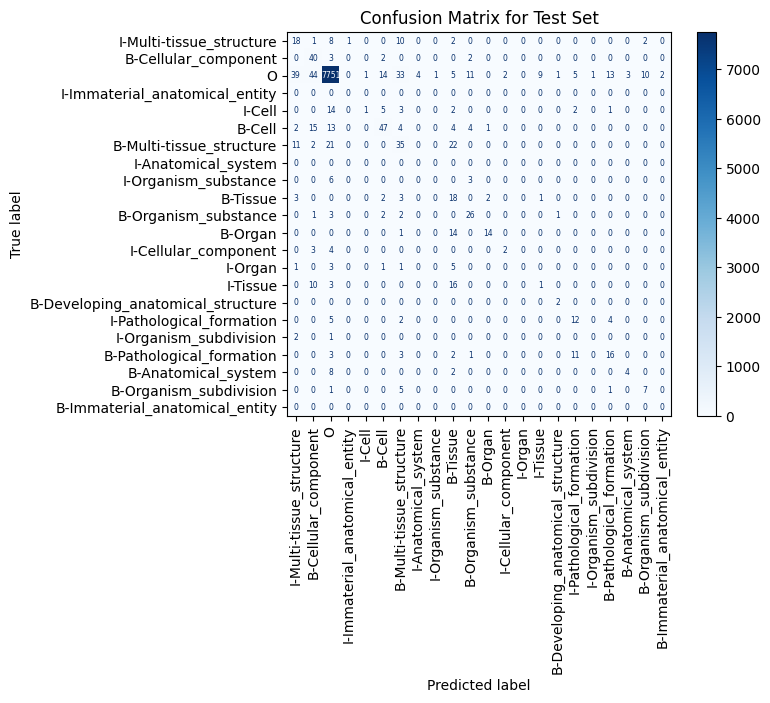

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Funzione per calcolare le predizioni e le etichette vere
def get_predictions_and_labels(trainer, dataset):
    # Ottieni predizioni dal modello
    predictions, labels, _ = trainer.predict(dataset)

    # Convertire le predizioni probabilistiche in etichette
    predictions = np.argmax(predictions, axis=2)

    # Filtra i token speciali (-100) dalle etichette
    true_labels = [
        [label for label in label_seq if label != -100]
        for label_seq in labels
    ]
    pred_labels = [
        [pred for pred, label in zip(pred_seq, label_seq) if label != -100]
        for pred_seq, label_seq in zip(predictions, labels)
    ]

    # Appiattire le liste per calcolare la matrice di confusione
    true_labels = [item for sublist in true_labels for item in sublist]
    pred_labels = [item for sublist in pred_labels for item in sublist]

    return true_labels, pred_labels

# Etichette vere e predette dal test set
true_labels, pred_labels = get_predictions_and_labels(trainer_fine_tuned, tokenized_datasets['test'])
# Calcolare la matrice di confusione
conf_matrix = confusion_matrix(true_labels, pred_labels, labels=list(tag2id.values()))

# Mappare gli ID delle etichette ai nomi dei tag NER
labels = [id2tag[id_] for id_ in tag2id.values()]
# Visualizzare la matrice di confusione con celle più grandi
plt.figure(figsize=(18, 15))  # Aumentare la dimensione della figura
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=90)

# Aggiungi uno spazio per evitare sovrapposizioni
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Aggiungi dimensione del testo per evitare sovrapposizioni
for text in disp.figure_.axes[0].texts:  # Usa axes[0] per accedere all'asse
    text.set_fontsize(5.5)  # Ridurre la dimensione del font per adattare i numeri

plt.title("Confusion Matrix for Test Set")
plt.show()

# Predictions
In this section, we test the model's NER tag predictions using the fine-tuned model. The fine-tuned model and tokenizer are loaded from the specified directory. The predict_ner function tokenizes a sentence, generates predictions from the model, and reconstructs the words with their corresponding NER labels, ignoring special tokens such as [CLS], [SEP], and [PAD]. Finally, we evaluate the model on new sentences to assess its ability to correctly identify and classify entities like Pathological_formation, Multi-tissue_structure, and others.

We can say that model correctly identified entities, labeling relevant words and classifying non-relevant ones as O. It demonstrated good ability to distinguish between medical entities and common words, with solid performance and good generalization on unseen sentences.


In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch

# Specificare la directory dove sono salvati i file
model_directory = "/content/drive/MyDrive/Assignment/fine_tuned_model"

# Caricare il modello fine-tunato e il tokenizer
model = AutoModelForTokenClassification.from_pretrained(model_directory)
tokenizer = AutoTokenizer.from_pretrained(model_directory)

# Funzione di predizione
def predict_ner(sentence):
    # Tokenizzare la frase
    inputs = tokenizer.encode_plus(
        sentence,
        return_tensors='pt',             # Restituisce l'output come tensori PyTorch
        is_split_into_words=False,       # Input è una frase completa
        truncation=True,
        max_length=128                   # Lunghezza max usata durante l'addestramento
    )
    input_ids = inputs['input_ids']

    model.eval()  # Metti il modello in modalità valutazione per evitare modifiche ai pesi

    # Ottenere le predizioni
    with torch.no_grad():
        outputs = model(**inputs)  # Ottieni i logits
        predictions = torch.argmax(outputs.logits, dim=2)[0].numpy()  # Per ogni token seleziona la classe con la probabilità più alta

    # Convertire input_ids in token
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Ricostruire le parole dai sub-token e assegnare le etichette
    words = []
    labels = []
    for idx, (token, pred) in enumerate(zip(tokens, predictions)):
        if token in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
            continue
        if token.startswith('##'):
            words[-1] += token[2:]  # Combina sub-token
        else:
            words.append(token)
            labels.append(id2tag[pred])  # Mappa l'indice della classe con il tag

    # Stampare le parole e le relative etichette
    print("\nPredizione:")
    print("Parola\tEtichetta")
    for word, label in zip(words, labels):
        print(f"{word}\t{label}")


# Test della funzione di predizione
print("\nEsempio di predizione:")
test_sentence_1 = "Aortic aneurysm was detected in the chest"
test_sentence_2 = "The fracture in the femur requires surgery"
predict_ner(test_sentence_1)
predict_ner(test_sentence_2)



Esempio di predizione:

Predizione:
Parola	Etichetta
aortic	I-Pathological_formation
aneurysm	B-Pathological_formation
was	O
detected	B-Pathological_formation
in	B-Pathological_formation
the	B-Pathological_formation
chest	B-Organism_subdivision

Predizione:
Parola	Etichetta
the	O
fracture	O
in	B-Multi-tissue_structure
the	B-Multi-tissue_structure
femur	B-Multi-tissue_structure
requires	O
surgery	O


In [ ]:

from transformers import AutoModelForTokenClassification, AutoTokenizer

# Percorso corretto
save_directory = '/content/drive/MyDrive/saved_model'

# Carica il modello e il tokenizer
model = AutoModelForTokenClassification.from_pretrained(save_directory, local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained(save_directory, local_files_only=True)

print("Modello e tokenizer caricati con successo!")



Modello e tokenizer caricati con successo!


# Conclusions
The results show that BioBERT, based on Transformer architecture, outperforms the BiLSTM model, despite the higher accuracy achieved with the latter.
Our dataset was highly imbalanced, which made it difficult to achieve good performance on the minority classes. During the training of BioBERT, we faced challenges such as addressing class imbalance using class weights and parameter tuning. However, BioBERT demonstrated a better ability to balance precision and recall compared to BiLSTM.

* Although BiLSTM achieved higher accuracy, BioBERT significantly outperforms it in terms of precision and recall. BiLSTM has a recall of 0.52 and precision of 0.26, whereas BioBERT strikes a better balance between these metrics, effectively reducing false positives.

* BioBERT showed superior recall, meaning it was better at identifying the majority of actual entities in the dataset, reducing false negatives.

* BioBERT achieved a higher F1 score compared to BiLSTM, indicating a better balance between precision and recall. The F1 score is critical for imbalanced datasets like ours, where accuracy alone is not sufficient, as it can be skewed by the majority classes.

**Possible Explanation for the Differences**
* Self-Attention and Contextual Understanding:
BioBERT leverages the self-attention mechanism, allowing it to effectively capture long-range dependencies between tokens, regardless of their distance in the sequence. This enables it to understand global context and model complex relationships, which is crucial for Named Entity Recognition, especially in long or complex sentences. BiLSTM, although bidirectional, has a more limited ability to handle long-range dependencies.

* Pretraining:
BioBERT is pre-trained on large biomedical corpora, acquiring domain-specific linguistic knowledge that enables it to recognize medical entities more effectively. On the other hand, BiLSTM, trained from scratch, must learn these relationships directly from the dataset.

* Tokenization:
BioBERT uses advanced tokenization, such as subword tokenization, which allows it to handle rare or unseen words more effectively. BiLSTM, with simpler tokenization, may struggle with rare or out-of-vocabulary terms.

* Model Complexity:
BioBERT has a higher capacity to model complex relationships due to its attention-based architecture, allowing it to handle more variables compared to BiLSTM, which, while simpler, has fewer parameters and less ability to learn intricate dependencies.

* Error Propagation:
Self-attention in BioBERT reduces error propagation by treating each token independently. In contrast, BiLSTM can accumulate errors, as each prediction depends on previous states, especially in long sequences.